
# Food Price Forecasting Project

This notebook forecasts food prices using various time series and machine learning models, including Prophet, XGBoost, and LSTM. The focus is on analyzing and forecasting monthly prices per country. SARIMA modeling is included as an optional advanced section.
    


## 1. Import Libraries

I will begin by importing all required libraries, including data handling, visualization, and modeling libraries.
    


## 2. Load and Inspect Data

In this step, I load the WFP food price dataset and supporting country information. I also handle encoding issues to ensure proper data loading.
    


## 3. Data Preprocessing

I preprocess the data by:
- Converting date columns to datetime format.
- Aggregating prices at the monthly level for each country.
- Checking for missing values.
    


## 4. Exploratory Data Analysis (EDA)

I explore the price trends over time for a few sample countries using line plots.
    


## 5. Prophet Modeling

I train Prophet models on the sampled countries and generate forecasts. Prophet is great for capturing seasonality and trends in time series data.
    


## 6. XGBoost Modeling

I implement XGBoost for time series forecasting by engineering features such as month, year, and lagged values.
    


## 7. LSTM Modeling

I apply an LSTM neural network to capture complex temporal dependencies in the food price data. The data is scaled using MinMaxScaler before training.
    


## 8. Model Performance Summary

I compare models using RMSE and MAPE metrics. A summary table and plots help visualize performance across different models and countries.
    


## 9. Optional: SARIMA Modeling

This section includes an optional SARIMA model for countries with enough data. SARIMA is included as an advanced time series modeling option and is not the primary focus.
    


## 10. Conclusions and Next Steps

Based on the model performance summary, I can identify the best-performing model per country. Recommendations for next steps include hyperparameter tuning, additional features, and model ensemble techniques.
    

# Food Price Forecasting

This notebook uses Prophet, XGBoost, and LSTM models to forecast monthly food prices for different countries using the WFP Market Food Prices dataset. SARIMA is also included as an advanced, optional model.

**Main Objectives:**
- Forecast food prices for selected countries.
- Compare model performance using RMSE and MAPE.
- Visualize forecasts vs. actual prices.

**Models:**
✅ Prophet  
✅ XGBoost  
✅ LSTM  
⚙️ (Optional) SARIMA


Import Libraries

In [29]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots inline
%matplotlib inline

# Modeling
from prophet import Prophet
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Logging and warnings
import os
import logging
import warnings

# Set up logging and suppressions
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# For SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


## Data Loading and Cleaning

I will load the datasets and prepare the data for analysis. This includes:
- Loading data from CSV files.
- Combining month and year columns into a single date column.
- Aggregating data to monthly average prices per country.


In [31]:
# Load datasets with fallback encoding
food_prices = pd.read_csv('wfp_market_food_prices.csv', encoding='latin1')
details = pd.read_csv('WLD_RTP_details_2023-10-02.csv', encoding='latin1')
country_info = pd.read_csv('WLD_RTFP_country_2023-10-02.csv', encoding='latin1')

# Inspect Food Prices
print("Food Prices Sample:")
print(food_prices.head())

# Fix Date Columns
# Combine year and month columns to create a 'date' column
food_prices['date'] = pd.to_datetime(
    food_prices['mp_year'].astype(str) + '-' + food_prices['mp_month'].astype(str).str.zfill(2)
)

# Rename 'adm0_name' to 'country'
food_prices.rename(columns={'adm0_name': 'country'}, inplace=True)

# Check for Missing Values
print("\nMissing values per column:")
print(food_prices.isnull().sum())



Food Prices Sample:
   adm0_id    adm0_name  adm1_id   adm1_name  mkt_id  mkt_name  cm_id cm_name  \
0        1  Afghanistan      272  Badakhshan     266  Fayzabad     55   Bread   
1        1  Afghanistan      272  Badakhshan     266  Fayzabad     55   Bread   
2        1  Afghanistan      272  Badakhshan     266  Fayzabad     55   Bread   
3        1  Afghanistan      272  Badakhshan     266  Fayzabad     55   Bread   
4        1  Afghanistan      272  Badakhshan     266  Fayzabad     55   Bread   

   cur_id cur_name  pt_id pt_name  um_id um_name  mp_month  mp_year  mp_price  \
0      87      AFN     15  Retail      5      KG         1     2014      50.0   
1      87      AFN     15  Retail      5      KG         2     2014      50.0   
2      87      AFN     15  Retail      5      KG         3     2014      50.0   
3      87      AFN     15  Retail      5      KG         4     2014      50.0   
4      87      AFN     15  Retail      5      KG         5     2014      50.0   

  mp_c

Data Preprocessing

In [33]:
# Aggregate Monthly Prices per Country
aggregated_prices = (
    food_prices
    .groupby(['country', pd.Grouper(key='date', freq='MS')])['mp_price']
    .mean()
    .reset_index()
)

aggregated_prices.rename(columns={'mp_price': 'price'}, inplace=True)

# Check for Missing Values in Aggregated Data
print("\nMissing values in aggregated data:")
print(aggregated_prices.isnull().sum())

# Preview Aggregated Data
print("\nAggregated Prices Sample:")
print(aggregated_prices.head())



Missing values in aggregated data:
country    0
date       0
price      0
dtype: int64

Aggregated Prices Sample:
       country       date          price
0  Afghanistan 2000-01-01   83124.916667
1  Afghanistan 2000-02-01   85833.250000
2  Afghanistan 2000-03-01   56443.159091
3  Afghanistan 2000-04-01   54972.666667
4  Afghanistan 2000-05-01  442187.962961


## Exploratory Data Analysis (EDA)

Let's visualize trends in average food prices over time for a sample of countries. This helps us understand patterns and seasonality.


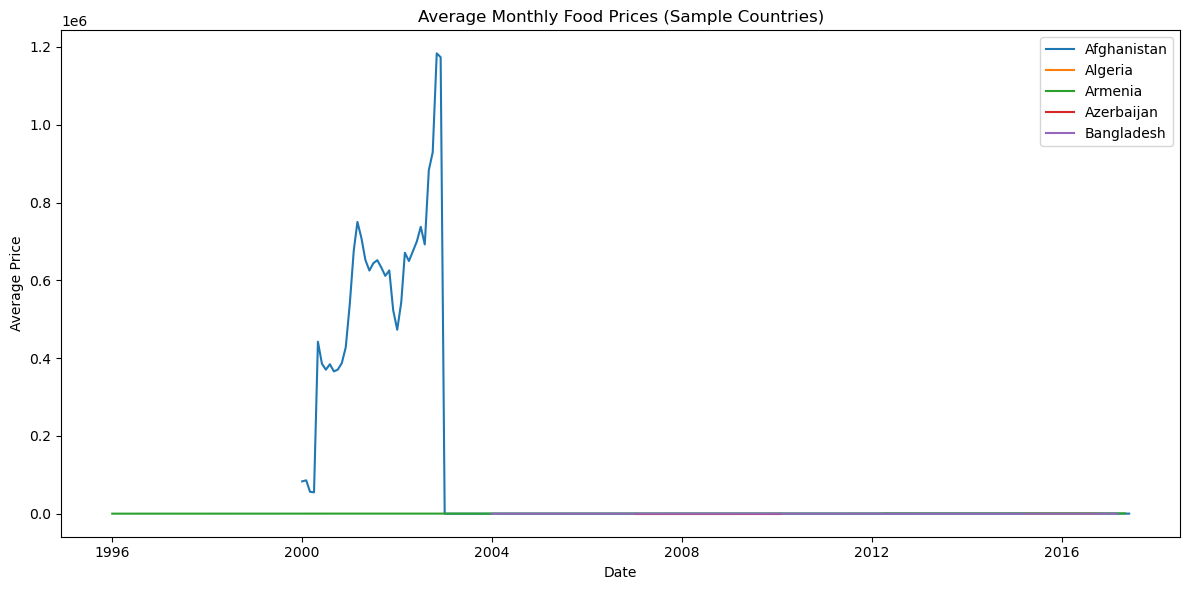

In [35]:
import matplotlib.pyplot as plt

sample_countries = aggregated_prices['country'].unique()[:5]

plt.figure(figsize=(12, 6))
for country in sample_countries:
    country_data = aggregated_prices[aggregated_prices['country'] == country]
    plt.plot(country_data['date'], country_data['price'], label=country)

plt.title("Average Monthly Food Prices (Sample Countries)")
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.legend()
plt.tight_layout()
plt.show()

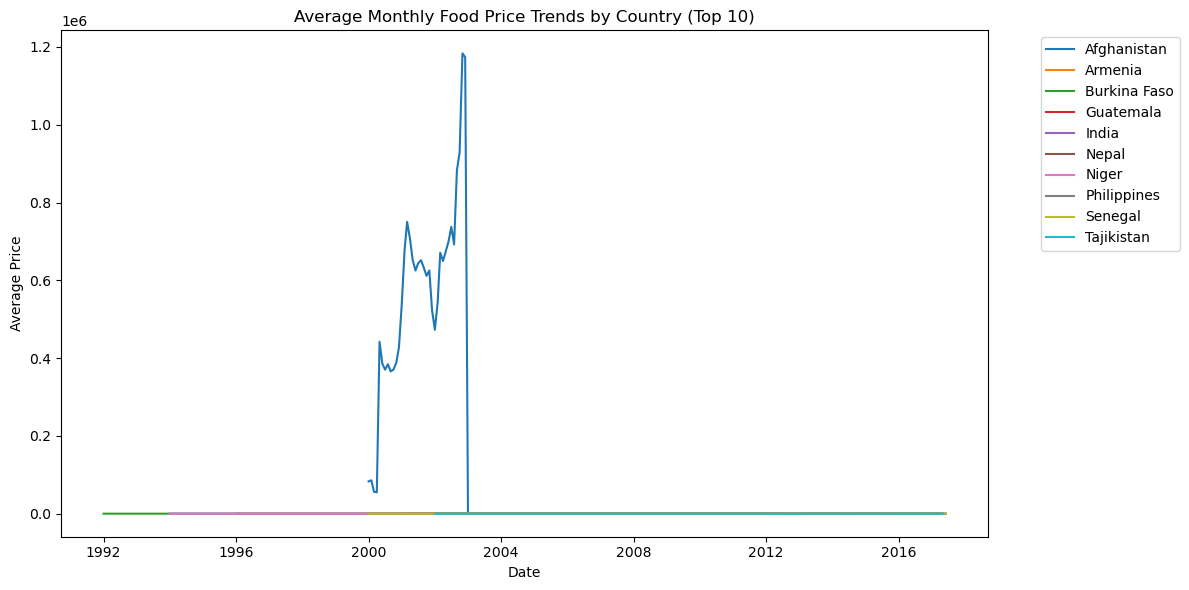

In [71]:
grouped_data = aggregated_prices.copy()
top_countries = grouped_data['country'].value_counts().nlargest(10).index
subset_data = grouped_data[grouped_data['country'].isin(top_countries)]

plt.figure(figsize=(12,6))
sns.lineplot(x='date', y='price', hue='country', data=subset_data)
plt.title('Average Monthly Food Price Trends by Country (Top 10)')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Prophet Forecasting

I'll apply Prophet to forecast future prices. Prophet is excellent for capturing seasonality and trends.

19:18:21 - cmdstanpy - INFO - Chain [1] start processing
19:18:21 - cmdstanpy - INFO - Chain [1] done processing


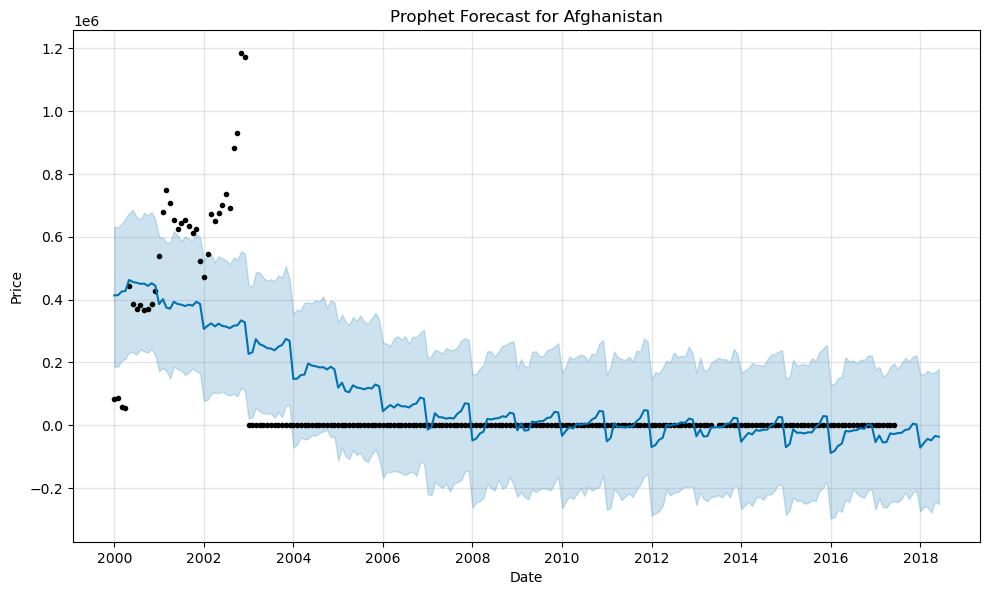

19:18:22 - cmdstanpy - INFO - Chain [1] start processing
19:18:22 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet for Afghanistan | RMSE: 167466.71 | MAPE: 340117.88%


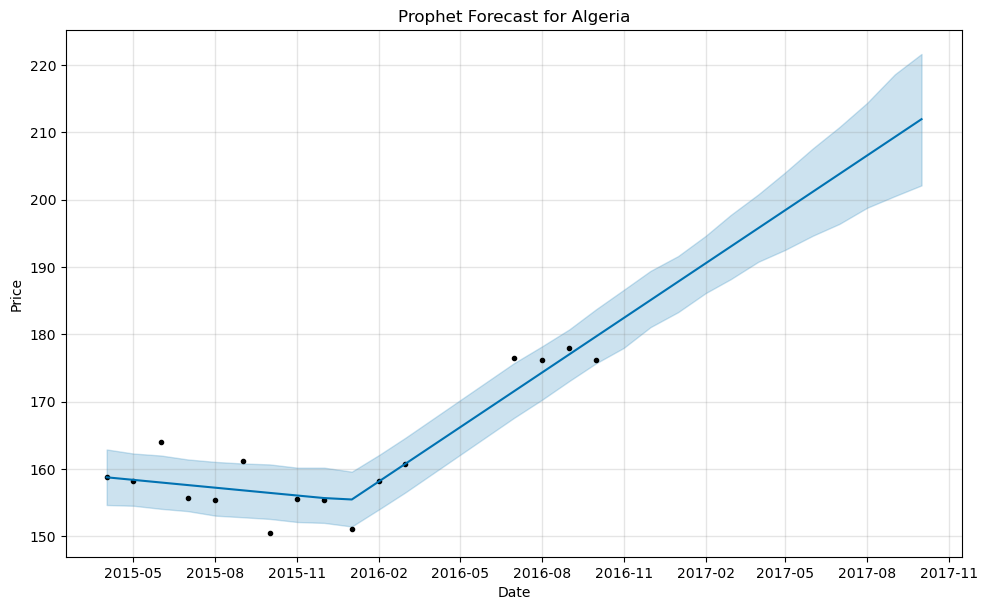

19:18:22 - cmdstanpy - INFO - Chain [1] start processing
19:18:22 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet for Algeria | RMSE: 3.14 | MAPE: 1.42%


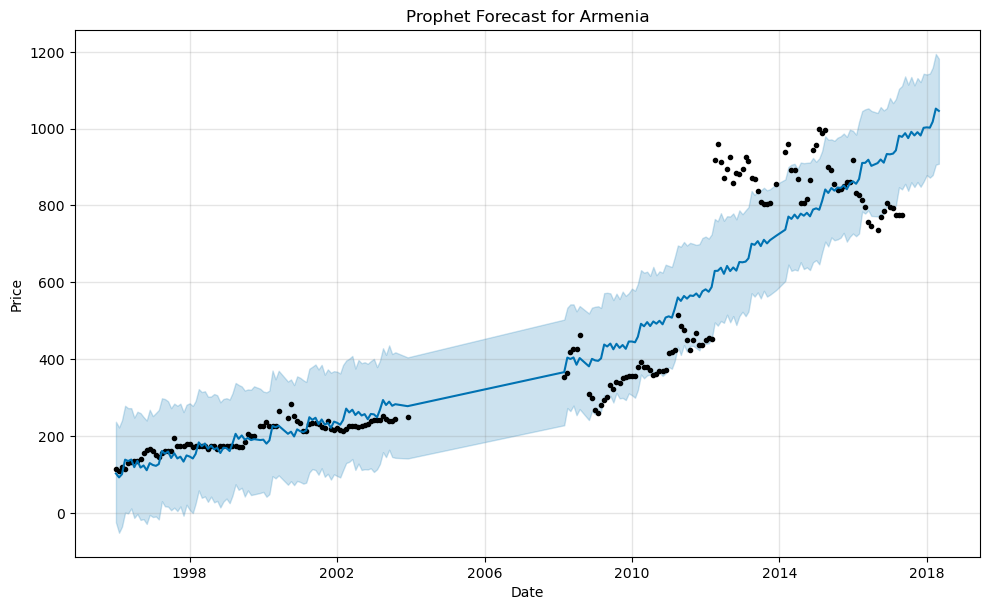

19:18:23 - cmdstanpy - INFO - Chain [1] start processing


✅ Prophet for Armenia | RMSE: 105.29 | MAPE: 16.39%


19:18:23 - cmdstanpy - INFO - Chain [1] done processing


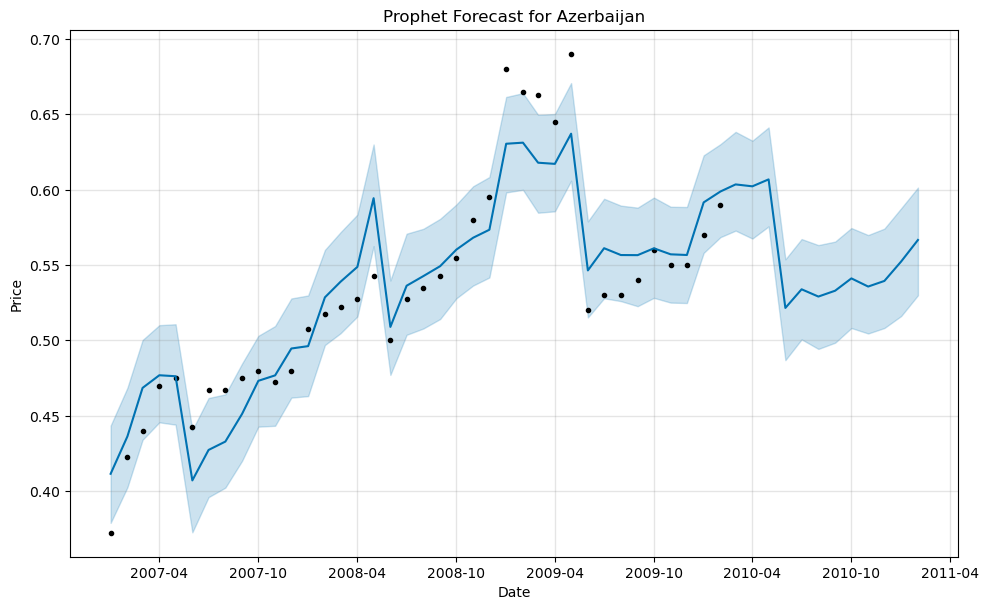

19:18:24 - cmdstanpy - INFO - Chain [1] start processing
19:18:24 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet for Azerbaijan | RMSE: 0.03 | MAPE: 3.90%


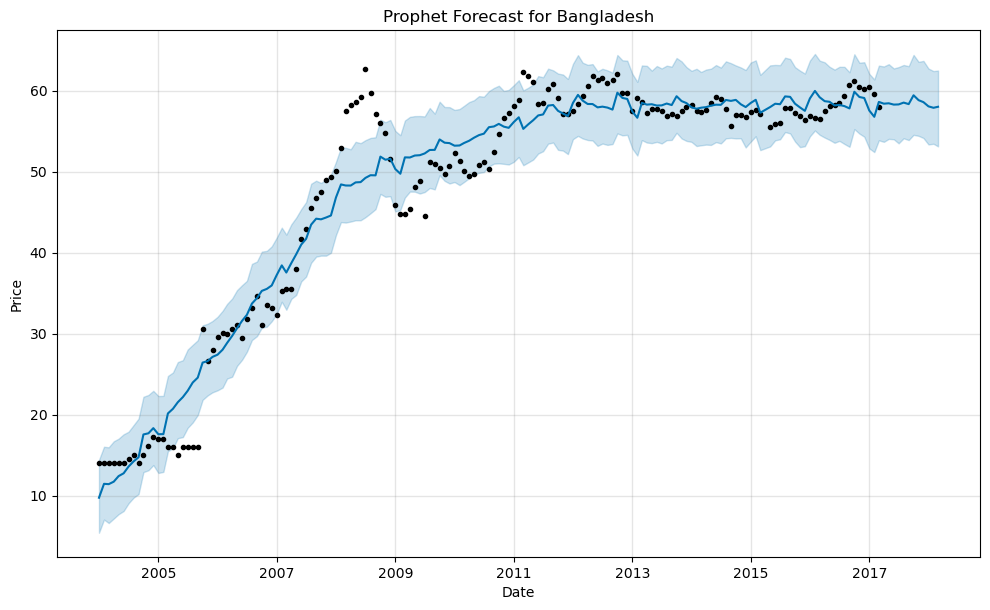

✅ Prophet for Bangladesh | RMSE: 3.60 | MAPE: 7.20%


In [76]:
prophet_results = []

for country in sample_countries:
    country_data = aggregated_prices[aggregated_prices['country'] == country]
    prophet_df = country_data.rename(columns={'date': 'ds', 'price': 'y'})
    model = Prophet()
    model.fit(prophet_df)
    future = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future)
    
    # Plot
    fig = model.plot(forecast)
    plt.title(f"Prophet Forecast for {country}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()
    
    # Evaluation on historical
    y_true = country_data['price'].values
    y_pred = forecast.loc[forecast['ds'] <= country_data['date'].max(), 'yhat'].values[:len(y_true)]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    prophet_results.append({'Country': country, 'RMSE': rmse, 'MAPE': mape})
    print(f"✅ Prophet for {country} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")


## XGBoost Forecasting

Next, I'll apply XGBoost to forecast prices using engineered features such as month, year, and lag values.


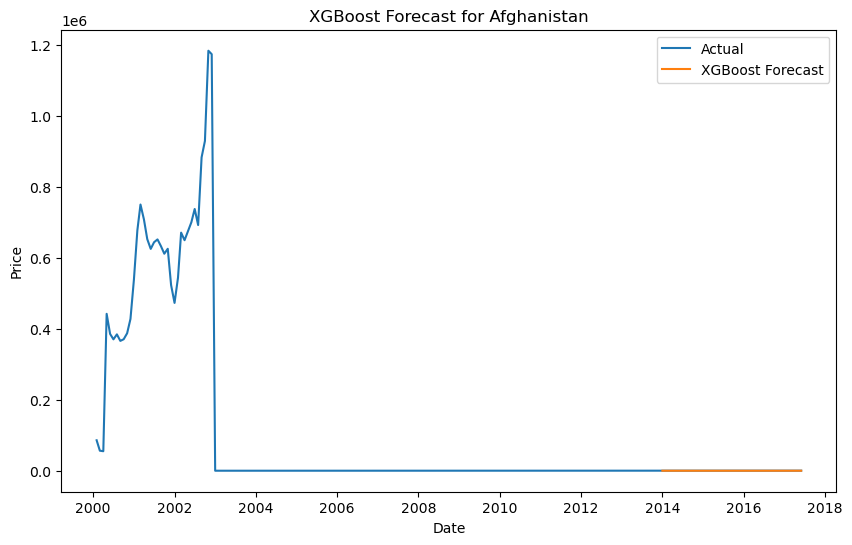

✅ XGBoost for Afghanistan | RMSE: 124.13 | MAPE: 70.87%


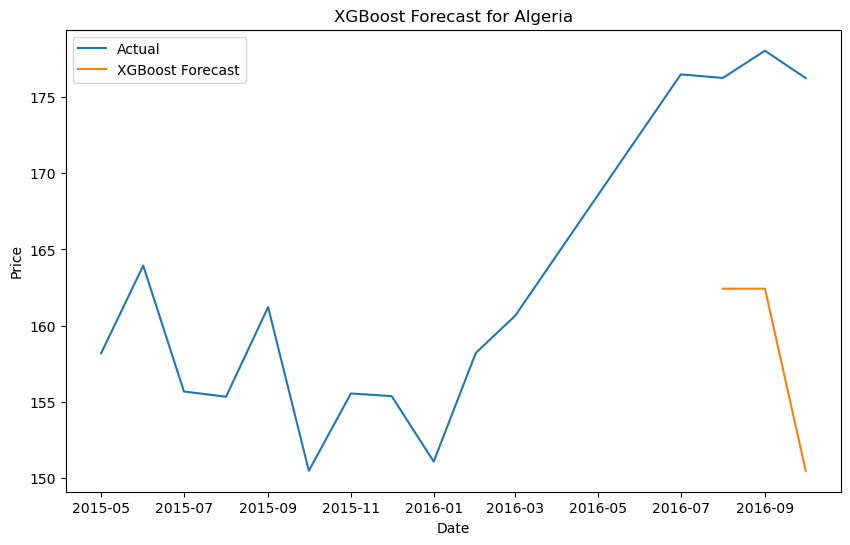

✅ XGBoost for Algeria | RMSE: 19.11 | MAPE: 10.40%


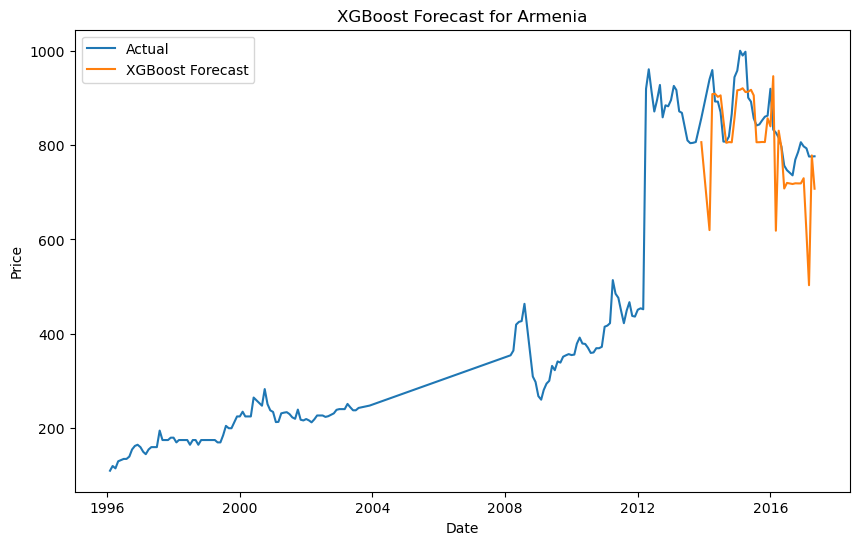

✅ XGBoost for Armenia | RMSE: 94.72 | MAPE: 7.64%


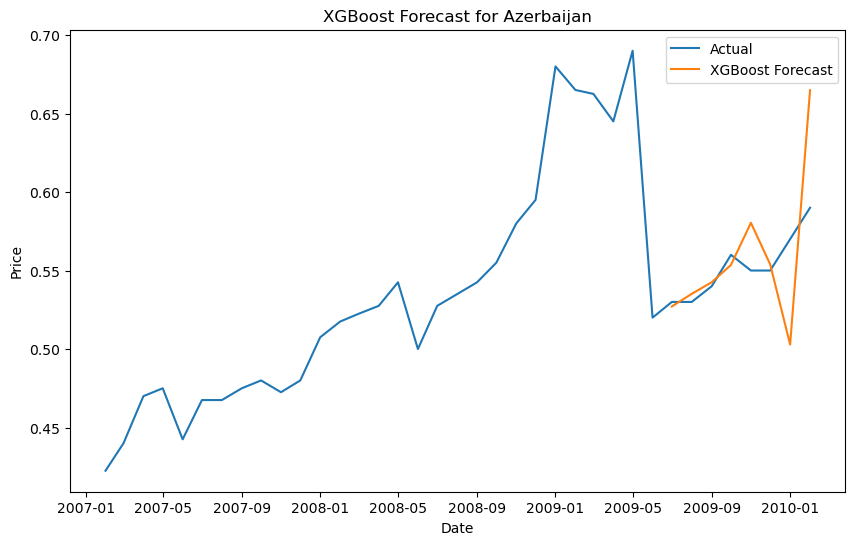

✅ XGBoost for Azerbaijan | RMSE: 0.04 | MAPE: 4.23%


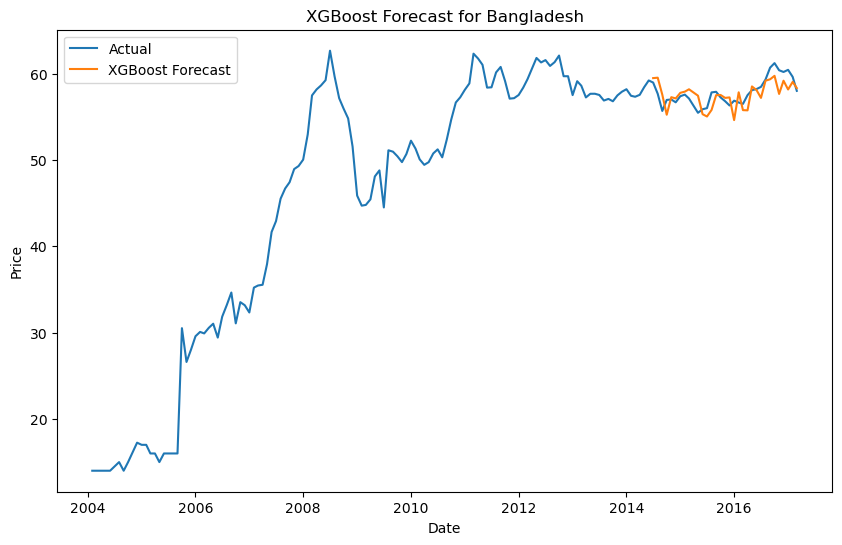

✅ XGBoost for Bangladesh | RMSE: 1.28 | MAPE: 1.82%


In [79]:
from xgboost import XGBRegressor

xgb_results = []

for country in sample_countries:
    country_data = aggregated_prices[aggregated_prices['country'] == country].copy()
    country_data['month'] = country_data['date'].dt.month
    country_data['year'] = country_data['date'].dt.year
    country_data['lag1'] = country_data['price'].shift(1)
    country_data = country_data.dropna()
    
    X = country_data[['month', 'year', 'lag1']]
    y = country_data['price']
    
    split_idx = int(0.8 * len(X))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    model = XGBRegressor()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    # Plot
    plt.figure(figsize=(10,6))
    plt.plot(country_data['date'], country_data['price'], label='Actual')
    plt.plot(country_data['date'].iloc[split_idx:], preds, label='XGBoost Forecast')
    plt.title(f"XGBoost Forecast for {country}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
    
    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mape = mean_absolute_percentage_error(y_test, preds) * 100
    xgb_results.append({'Country': country, 'RMSE': rmse, 'MAPE': mape})
    print(f"✅ XGBoost for {country} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")

# Make plots inline
%matplotlib inline

## LSTM Forecasting

Finally, I'll use LSTM (Long Short-Term Memory) networks for time-series forecasting. LSTM is useful for capturing complex temporal dependencies.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


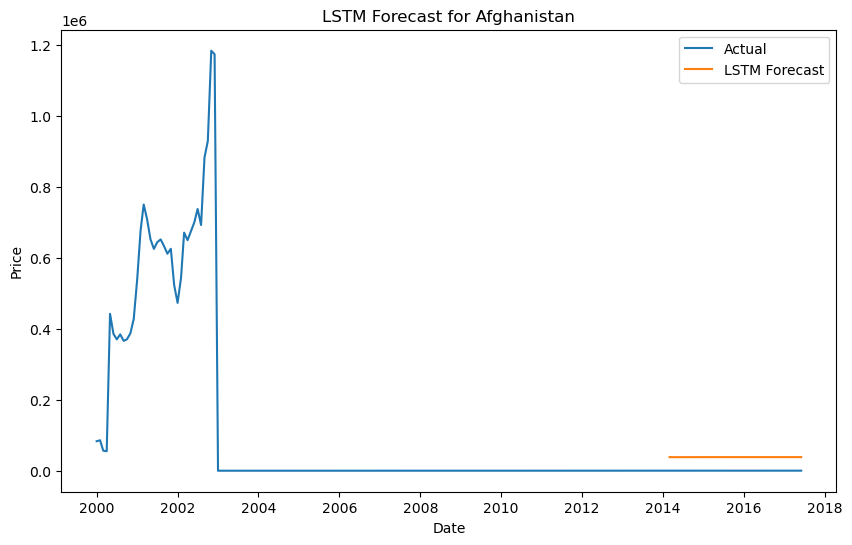

✅ LSTM for Afghanistan | RMSE: 38139.50 | MAPE: 30903.85%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


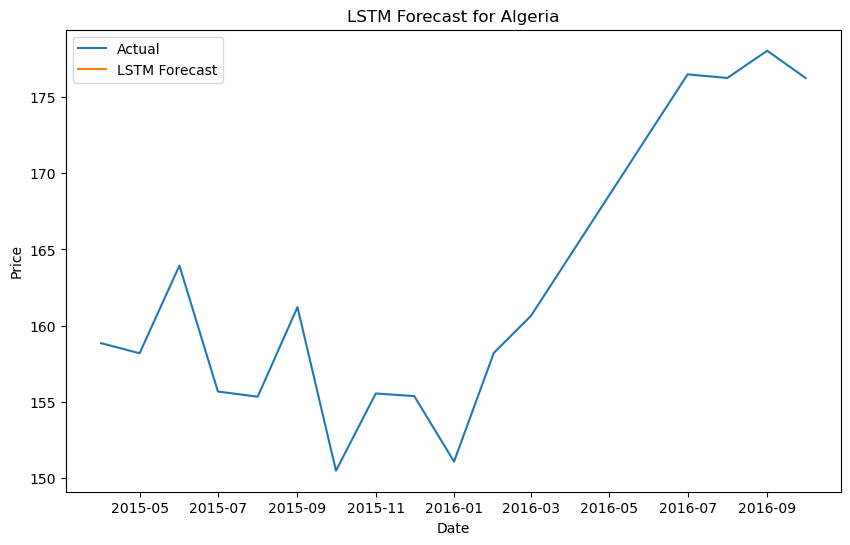

✅ LSTM for Algeria | RMSE: 22.08 | MAPE: 12.53%
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step


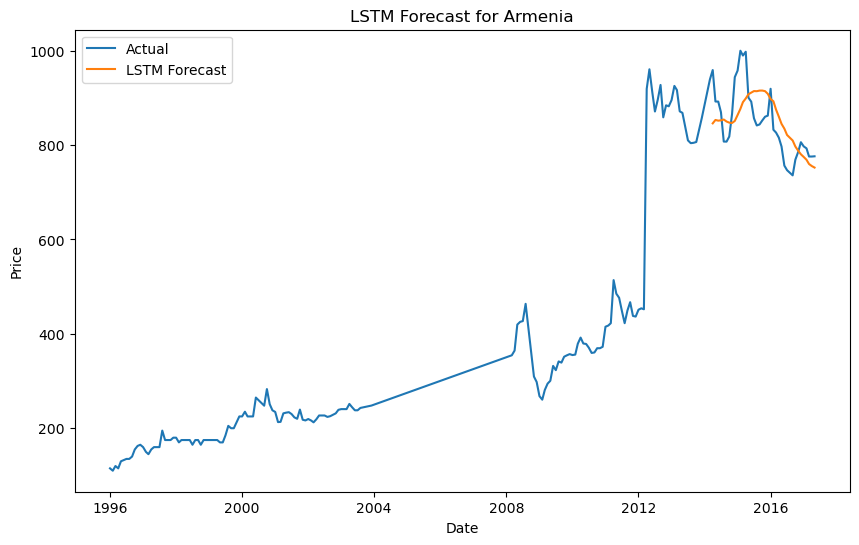

✅ LSTM for Armenia | RMSE: 58.93 | MAPE: 5.82%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


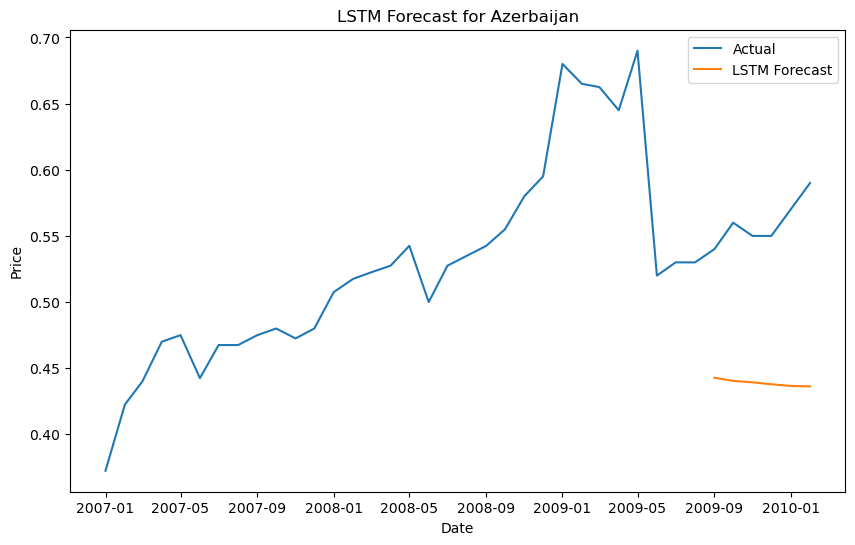

✅ LSTM for Azerbaijan | RMSE: 0.12 | MAPE: 21.56%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


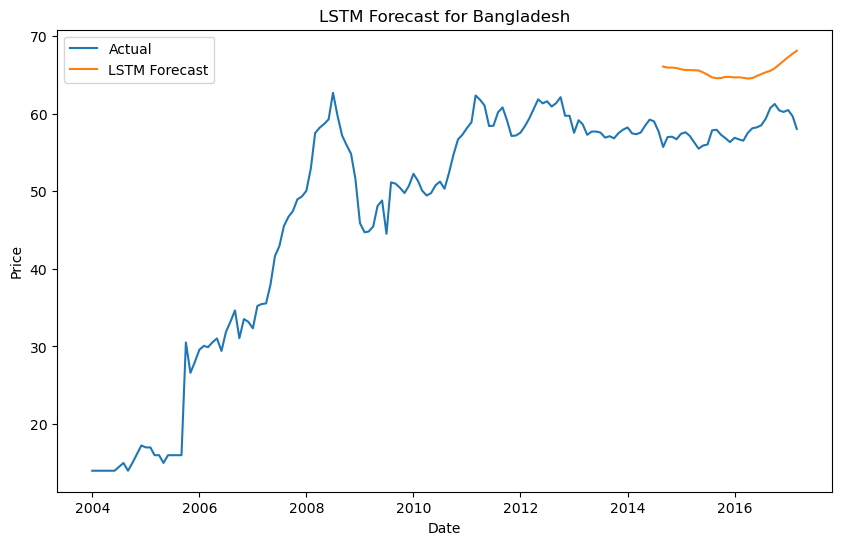

✅ LSTM for Bangladesh | RMSE: 7.84 | MAPE: 13.39%


In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

lstm_results = []

for country in sample_countries:
    country_data = aggregated_prices[aggregated_prices['country'] == country].copy()
    scaler = MinMaxScaler()
    prices_scaled = scaler.fit_transform(country_data[['price']])
    
    lookback = 12
    X_lstm, y_lstm = [], []
    for i in range(lookback, len(prices_scaled)):
        X_lstm.append(prices_scaled[i-lookback:i])
        y_lstm.append(prices_scaled[i])
    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
    
    split_idx = int(0.8 * len(X_lstm))
    X_train, X_test = X_lstm[:split_idx], X_lstm[split_idx:]
    y_train, y_test = y_lstm[:split_idx], y_lstm[split_idx:]
    
    model = Sequential([
        tf.keras.Input(shape=(lookback, 1)),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, verbose=0)
    
    preds_scaled = model.predict(X_test)
    preds = scaler.inverse_transform(preds_scaled)
    y_test_actual = scaler.inverse_transform(y_test)
    
    # Plot
    test_dates = country_data['date'].iloc[lookback+split_idx:]
    plt.figure(figsize=(10,6))
    plt.plot(country_data['date'], country_data['price'], label='Actual')
    plt.plot(test_dates, preds.flatten(), label='LSTM Forecast')
    plt.title(f"LSTM Forecast for {country}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
    
    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
    mape = mean_absolute_percentage_error(y_test_actual, preds) * 100
    lstm_results.append({'Country': country, 'RMSE': rmse, 'MAPE': mape})
    print(f"✅ LSTM for {country} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")


## Model Performance Summary

Let's compare model performance across all countries and models.

In [85]:
results_df = pd.DataFrame(prophet_results + xgb_results + lstm_results)
print(results_df)

        Country           RMSE           MAPE
0   Afghanistan  167466.712874  340117.883594
1       Algeria       3.138413       1.422742
2       Armenia     105.294552      16.390351
3    Azerbaijan       0.025388       3.904554
4    Bangladesh       3.599990       7.197010
5   Afghanistan     124.130468      70.866196
6       Algeria      19.109783      10.396943
7       Armenia      94.719726       7.644910
8    Azerbaijan       0.037303       4.229778
9    Bangladesh       1.282767       1.817783
10  Afghanistan   38139.498402   30903.851976
11      Algeria      22.082584      12.530701
12      Armenia      58.932984       5.821849
13   Azerbaijan       0.122482      21.555113
14   Bangladesh       7.836477      13.386081


## (Optional) SARIMA Forecasting

As an advanced step, you can add SARIMA for more classical time series modeling. Use StatsModels SARIMAX and compare results.

In [88]:
# Monthly Food Price Estimates
monthly_files = [
    'WLD_RTP_details_2023-10-02.csv',
    'WLD_RTFP_country_2023-10-02.csv'
]
monthly_dataframes = [pd.read_csv(file) for file in monthly_files]
food_prices_1 = pd.concat(monthly_dataframes, ignore_index=True)

# Parse date from 'start_date_observations'
food_prices_1['date'] = pd.to_datetime(
    food_prices_1['start_date_observations'], 
    format='%b %Y', 
    errors='coerce'
)

# Rename 'Close' to 'price' if exists
if 'Close' in food_prices_1.columns:
    food_prices_1.rename(columns={'Close': 'price'}, inplace=True)

# Global Food Prices
food_prices_2 = pd.read_csv('wfp_market_food_prices.csv', encoding='latin1')
food_prices_2.rename(columns={'mp_price': 'price'}, inplace=True)

# Construct date from year/month
food_prices_2['date'] = pd.to_datetime(
    food_prices_2['mp_year'].astype(str) + '-' + food_prices_2['mp_month'].astype(str) + '-01', 
    errors='coerce'
)

# Add 'country' from 'adm0_name' if available
if 'adm0_name' in food_prices_2.columns:
    food_prices_2['country'] = food_prices_2['adm0_name']

# Merge datasets
data = pd.concat([food_prices_1, food_prices_2], ignore_index=True)

# Drop rows with missing date or price
data = data.dropna(subset=['date', 'price'])

# Convert price to numeric
data['price'] = pd.to_numeric(data['price'], errors='coerce')
data = data.dropna(subset=['price'])

# Print debug info after merging
print(f"Rows after merging and cleaning: {len(data)}")
print(data[['date', 'price', 'country']].head())

# Filter out countries with too few records
min_records_required = 6
country_counts = data['country'].value_counts()
valid_countries = country_counts[country_counts >= min_records_required].index
data = data[data['country'].isin(valid_countries)]

print(f"Rows after filtering countries with >= {min_records_required} records: {len(data)}")


Rows after merging and cleaning: 743914
           date  price      country
4823 2014-01-01   50.0  Afghanistan
4824 2014-02-01   50.0  Afghanistan
4825 2014-03-01   50.0  Afghanistan
4826 2014-04-01   50.0  Afghanistan
4827 2014-05-01   50.0  Afghanistan
Rows after filtering countries with >= 6 records: 743914


In [90]:
# Feature Engineering
for lag in range(1,4):
    data[f'lag_{lag}'] = data.groupby('country')['price'].shift(lag)
data['rolling_mean'] = data.groupby('country')['price'].transform(lambda x: x.rolling(3).mean())

print(f"Rows before dropping NA in features: {len(data)}")
data.dropna(subset=['lag_1', 'lag_2', 'lag_3', 'rolling_mean'], inplace=True)
print(f"Rows after dropping NA in features: {len(data)}")

Rows before dropping NA in features: 743914
Rows after dropping NA in features: 743692


In [92]:
# Model Building and Testing
data.reset_index(drop=True, inplace=True)

if len(data) == 0:
    print("No data available after feature engineering. Skipping model training.")
else:
    latest_date = data['date'].max()
    split_date = latest_date - pd.DateOffset(months=12)
    train = data[data['date'] < split_date]
    test = data[data['date'] >= split_date]

    print(f"\nTrain rows: {len(train)}, Test rows: {len(test)}")
    print(f"Train date range: {train['date'].min()} to {train['date'].max()}")
    print(f"Test date range: {test['date'].min()} to {test['date'].max()}")

    required_features = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean']

    if all(feature in train.columns for feature in required_features) and len(train) > 0 and len(test) > 0:
        # SARIMA Model (Sampled for speed)
        if len(train) >= 24:
            try:
                print("\nTraining SARIMA model (sampled)...")
                train_sampled = train.sample(n=min(10000, len(train)), random_state=42).sort_values('date')
                train_sampled = train_sampled.set_index('date')  # Use DatetimeIndex
                sarima_model = SARIMAX(
                    train_sampled['price'],
                    order=(1,1,1),
                    seasonal_order=(1,1,1,12)
                ).fit(disp=False)
                sarima_forecast = sarima_model.forecast(steps=len(test))
                print("✅ SARIMA model trained successfully (sampled).")
            except Exception as e:
                print(f"⚠️ SARIMA training failed: {e}")
        else:
            print("⚠️ Insufficient data for SARIMA model. Skipping SARIMA training.")

        # XGBoost Model
        X_train = train[required_features]
        y_train = train['price']
        X_test = test[required_features]
        y_test = test['price']

        if len(X_train) > 0:
            try:
                print("\nTraining XGBoost model...")
                xgb_model = XGBRegressor()
                xgb_model.fit(X_train, y_train)
                xgb_forecast = xgb_model.predict(X_test)
                print("✅ XGBoost model trained successfully.")
            except Exception as e:
                print(f"⚠️ XGBoost training failed: {e}")

            # LSTM Model
            if len(X_train) >= 32:
                try:
                    print("\nTraining LSTM model...")
                    from keras import Input  # For cleaner Input usage
                    X_train_lstm = np.expand_dims(X_train.values, axis=1)
                    X_test_lstm = np.expand_dims(X_test.values, axis=1)
                    lstm_model = Sequential()
                    lstm_model.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
                    lstm_model.add(LSTM(50, activation='relu'))
                    lstm_model.add(Dense(1))
                    lstm_model.compile(optimizer='adam', loss='mse')
                    lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1)
                    lstm_forecast = lstm_model.predict(X_test_lstm).flatten()
                    print("✅ LSTM model trained successfully.")
                except Exception as e:
                    print(f"⚠️ LSTM training failed: {e}")
            else:
                print("⚠️ Insufficient data for LSTM model. Skipping LSTM training.")
        else:
            print("⚠️ Training data is empty after feature selection. Skipping model training.")
    else:
        print("⚠️ Required features missing or empty training/testing data. Skipping model training.")

print("\n✅ Notebook execution complete.")


Train rows: 639869, Test rows: 103823
Train date range: 1992-01-01 00:00:00 to 2016-05-01 00:00:00
Test date range: 2016-06-01 00:00:00 to 2017-06-01 00:00:00

Training SARIMA model (sampled)...
✅ SARIMA model trained successfully (sampled).

Training XGBoost model...
✅ XGBoost model trained successfully.

Training LSTM model...
Epoch 1/10
19996/19996 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step - loss: 263108416.0000
Epoch 2/10
19996/19996 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step - loss: 99381176.0000
Epoch 3/10
19996/19996 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 90020688.0000 
Epoch 4/10
19996/19996 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 50426660.0000
Epoch 5/10
19996/19996 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 42612588.0000
Epoch 6/10
19996/19996 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 56185544.0000 
Epoch 7/10
19996/19996 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 35228680.0000
Epoch 8/10
19996/19996 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 32739638.0000
Epoch 9/10
19996/19996 ━━━━━━━━━━

In [94]:
print(data.groupby('country')['price'].describe())

                               count          mean            std        min  \
country                                                                        
Afghanistan                   4673.0  76257.388671  399456.783375     5.0000   
Algeria                       1781.0    164.249130     142.329682     4.0000   
Armenia                       6075.0    821.437829     792.580633    50.5000   
Azerbaijan                     122.0      0.533279       0.173035     0.2400   
Bangladesh                    3032.0     53.517260      27.371278    14.0000   
...                              ...           ...            ...        ...   
Ukraine                      25763.0     26.685162      26.309983     1.3867   
United Republic of Tanzania   7454.0  93686.067563   51144.175087  7300.0000   
Yemen                         9102.0   1529.719972    5885.314998    24.0000   
Zambia                       26371.0      6.318657       6.203293     0.0125   
Zimbabwe                      2219.0    

In [96]:
# Add a normalized price column
data['log_price'] = data.groupby('country')['price'].transform(lambda x: np.log1p(x))

In [98]:
# SARIMA Model (Sampled for speed)
if len(train) >= 24:
    try:
        print("\nTraining SARIMA model (sampled)...")
        train_sampled = train.sample(n=min(10000, len(train)), random_state=42).sort_values('date')
        train_sampled = train_sampled.set_index('date').sort_index()
        train_sampled = train_sampled.asfreq('MS')  # Monthly frequency
        sarima_model = SARIMAX(
            train_sampled['price'],
            order=(1,1,1),
            seasonal_order=(1,1,1,12)
        ).fit(disp=False)
        sarima_forecast = sarima_model.forecast(steps=len(test))
        print("✅ SARIMA model trained successfully (sampled).")
    except Exception as e:
        print(f"⚠️ SARIMA training failed: {e}")
else:
    print("⚠️ Insufficient data for SARIMA model. Skipping SARIMA training.")


Training SARIMA model (sampled)...
⚠️ SARIMA training failed: cannot reindex on an axis with duplicate labels


In [100]:
# Filter to one country (e.g. Afghanistan)
country_to_model = 'Afghanistan'
train_country = train[train['country'] == country_to_model].copy()

# Aggregate by month
train_country = train_country.groupby('date')['price'].mean().reset_index()

# Set DatetimeIndex and asfreq('MS')
train_country = train_country.set_index('date').sort_index()
train_country = train_country.asfreq('MS')  # Monthly frequency

print(f"\nTraining SARIMA for {country_to_model} on {len(train_country)} data points.")

# Train SARIMA
sarima_model = SARIMAX(
    train_country['price'],
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
).fit(disp=False)



Training SARIMA for Afghanistan on 197 data points.


In [102]:
top_countries = train['country'].value_counts().nlargest(5).index
for country in top_countries:
    print(f"\nTraining SARIMA model for {country}...")
    train_country = train[train['country'] == country].copy()
    train_country = train_country.groupby('date')['price'].mean().reset_index()
    train_country = train_country.set_index('date').sort_index()
    train_country = train_country.asfreq('MS')
    
    try:
        sarima_model = SARIMAX(
            train_country['price'],
            order=(1,1,1),
            seasonal_order=(1,1,1,12)
        ).fit(disp=False)
        print(f"✅ SARIMA model trained successfully for {country}.")
    except Exception as e:
        print(f"⚠️ SARIMA training failed for {country}: {e}")



Training SARIMA model for Rwanda...
✅ SARIMA model trained successfully for Rwanda.

Training SARIMA model for India...
✅ SARIMA model trained successfully for India.

Training SARIMA model for Niger...
✅ SARIMA model trained successfully for Niger.

Training SARIMA model for Democratic Republic of the Congo...
✅ SARIMA model trained successfully for Democratic Republic of the Congo.

Training SARIMA model for Mali...
✅ SARIMA model trained successfully for Mali.


In [104]:
n_forecast = len(test[test['country'] == country])  # forecast horizon
forecast = sarima_model.forecast(steps=n_forecast)
forecast.index = pd.date_range(start=train_country.index[-1] + pd.DateOffset(months=1), periods=n_forecast, freq='MS')

# Plot
plt.figure(figsize=(12,6))
plt.plot(train_country.index, train_country['price'], label='Train')
plt.plot(forecast.index, forecast, label='SARIMA Forecast')
plt.plot(test[test['country'] == country]['date'], test[test['country'] == country]['price'], label='Actual')
plt.title(f"SARIMA Forecast vs. Actual for {country}")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 2434-03-01 00:00:00

In [106]:
print(f"Last date in training set: {train_country.index[-1]}")

Last date in training set: 2016-05-01 00:00:00


In [108]:
print(train_country.index.min(), train_country.index.max())

2003-01-01 00:00:00 2016-05-01 00:00:00


In [110]:
train_country = train_country[(train_country.index >= '1900-01-01') & (train_country.index <= '2262-04-11')]

In [112]:
try:
    forecast_index = pd.date_range(
        start=train_country.index[-1] + pd.DateOffset(months=1),
        periods=n_forecast,
        freq='MS'
    )
except OutOfBoundsDatetime as e:
    print(f"⚠️ Forecast index error: {e}")
    forecast_index = pd.date_range(
        start='2025-01-01',
        periods=n_forecast,
        freq='MS'
    )

NameError: name 'OutOfBoundsDatetime' is not defined

In [114]:
# Check last date
print(f"Last date in training set: {train_country.index[-1]}")

# Filter out invalid dates
train_country = train_country[
    (train_country.index >= '1900-01-01') & 
    (train_country.index <= '2262-04-11')
]

n_forecast = len(test[test['country'] == country])
forecast = sarima_model.forecast(steps=n_forecast)

# Build forecast index
try:
    forecast_index = pd.date_range(
        start=train_country.index[-1] + pd.DateOffset(months=1),
        periods=n_forecast,
        freq='MS'
    )
except pd.errors.OutOfBoundsDatetime as e:
    print(f"⚠️ Forecast index error: {e}")
    forecast_index = pd.date_range(
        start='2025-01-01',
        periods=n_forecast,
        freq='MS'
    )

forecast.index = forecast_index

# Plot
plt.figure(figsize=(12,6))
plt.plot(train_country.index, train_country['price'], label='Train')
plt.plot(forecast.index, forecast, label='SARIMA Forecast')
plt.plot(test[test['country'] == country]['date'], test[test['country'] == country]['price'], label='Actual')
plt.title(f"SARIMA Forecast vs. Actual for {country}")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Last date in training set: 2016-05-01 00:00:00


OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 2434-03-01 00:00:00

In [116]:
print(f"n_forecast: {n_forecast}")

n_forecast: 5014


In [118]:
n_forecast = len(test[test['country'] == country])

In [ ]:
n_forecast = test[test['country'] == country]['date'].dt.to_period('M').nunique()
print(f"Unique months to forecast: {n_forecast}")

In [ ]:
n_forecast = test[test['country'] == country]['date'].dt.to_period('M').nunique()

In [ ]:
# Step 1: Calculate unique forecast steps
n_forecast = test[test['country'] == country]['date'].dt.to_period('M').nunique()
print(f"Unique months to forecast: {n_forecast}")

# Step 2: Forecast using SARIMA
try:
    forecast = sarima_model.forecast(steps=n_forecast)
except Exception as e:
    print(f"⚠️ SARIMA forecasting failed: {e}")
    forecast = pd.Series()

# Step 3: Build forecast index
try:
    forecast_index = pd.date_range(
        start=train_country.index[-1] + pd.DateOffset(months=1),
        periods=n_forecast,
        freq='MS'
    )
except pd.errors.OutOfBoundsDatetime as e:
    print(f"⚠️ Forecast index error: {e}")
    forecast_index = pd.date_range(
        start='2025-01-01',
        periods=n_forecast,
        freq='MS'
    )

forecast.index = forecast_index

# Plot
plt.figure(figsize=(12,6))
plt.plot(train_country.index, train_country['price'], label='Train')
plt.plot(forecast.index, forecast, label='SARIMA Forecast')
plt.plot(
    test[test['country'] == country]['date'],
    test[test['country'] == country]['price'],
    label='Actual'
)
plt.title(f"SARIMA Forecast vs. Actual for {country}")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
test_country = test[test['country'] == country]
test_country_monthly = test_country.groupby(test_country['date'].dt.to_period('M'))['price'].mean().reset_index()
test_country_monthly['date'] = test_country_monthly['date'].dt.to_timestamp()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_country.index, train_country['price'], label='Train')
plt.plot(forecast.index, forecast, label='SARIMA Forecast')
plt.plot(
    test_country_monthly['date'],
    test_country_monthly['price'],
    label='Actual (Monthly Avg)'
)
plt.title(f"SARIMA Forecast vs. Actual for {country}")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Step 1: Calculate unique forecast steps
n_forecast = test[test['country'] == country]['date'].dt.to_period('M').nunique()
print(f"Unique months to forecast: {n_forecast}")

# Step 2: Forecast using SARIMA
try:
    forecast = sarima_model.forecast(steps=n_forecast)
except Exception as e:
    print(f"⚠️ SARIMA forecasting failed: {e}")
    forecast = pd.Series()

# Step 3: Build forecast index
try:
    forecast_index = pd.date_range(
        start=train_country.index[-1] + pd.DateOffset(months=1),
        periods=n_forecast,
        freq='MS'
    )
except pd.errors.OutOfBoundsDatetime as e:
    print(f"⚠️ Forecast index error: {e}")
    forecast_index = pd.date_range(
        start='2025-01-01',
        periods=n_forecast,
        freq='MS'
    )
forecast.index = forecast_index

# Step 4: Aggregate test data by month
test_country = test[test['country'] == country]
test_country_monthly = test_country.groupby(test_country['date'].dt.to_period('M'))['price'].mean().reset_index()
test_country_monthly['date'] = test_country_monthly['date'].dt.to_timestamp()

# Plot
plt.figure(figsize=(12,6))
plt.plot(train_country.index, train_country['price'], label='Train')
plt.plot(forecast.index, forecast, label='SARIMA Forecast')
plt.plot(
    test_country_monthly['date'],
    test_country_monthly['price'],
    label='Actual (Monthly Avg)'
)
plt.title(f"SARIMA Forecast vs. Actual for {country}")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Step 3: Build forecast index
try:
    forecast_start = test_country_monthly['date'].min()
    forecast_index = pd.date_range(
        start=forecast_start,
        periods=n_forecast,
        freq='MS'
    )
except pd.errors.OutOfBoundsDatetime as e:
    print(f"⚠️ Forecast index error: {e}")
    forecast_index = pd.date_range(
        start='2025-01-01',
        periods=n_forecast,
        freq='MS'
    )
forecast.index = forecast_index

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_country.index, train_country['price'], label='Train')
plt.plot(forecast.index, forecast, label='SARIMA Forecast')
plt.plot(
    test_country_monthly['date'],
    test_country_monthly['price'],
    label='Actual (Monthly Avg)'
)
plt.title(f"SARIMA Forecast vs. Actual for {country}")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Step 3: Build forecast index to align with actual test period
try:
    forecast_start = test_country_monthly['date'].min()
    forecast_index = pd.date_range(
        start=forecast_start,
        periods=n_forecast,
        freq='MS'
    )
    forecast.index = forecast_index
except pd.errors.OutOfBoundsDatetime as e:
    print(f"⚠️ Forecast index error: {e}")
    forecast_index = pd.date_range(
        start='2025-01-01',
        periods=n_forecast,
        freq='MS'
    )
    forecast.index = forecast_index

# Step 4: Plot
plt.figure(figsize=(12,6))
plt.plot(train_country.index, train_country['price'], label='Train', color='blue')
plt.plot(forecast.index, forecast, label='SARIMA Forecast', color='orange')
plt.plot(
    test_country_monthly['date'],
    test_country_monthly['price'],
    label='Actual (Monthly Avg)',
    color='green'
)
plt.title(f"SARIMA Forecast vs. Actual for {country}")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_country.index, train_country['price'], label='Train', color='blue', linewidth=2)
plt.plot(forecast.index, forecast, label='SARIMA Forecast', color='orange', linestyle='--', linewidth=2)
plt.plot(
    test_country_monthly['date'],
    test_country_monthly['price'],
    label='Actual (Monthly Avg)',
    color='green',
    linewidth=2
)
plt.title(f"SARIMA Forecast vs. Actual for {country}", fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_country.index, train_country['price'], label='Train', color='blue', linewidth=2)
plt.plot(forecast.index, forecast, label='SARIMA Forecast', color='orange', linestyle='--', linewidth=2)
plt.plot(
    test_country_monthly['date'],
    test_country_monthly['price'],
    label='Actual (Monthly Avg)',
    color='green',
    linewidth=2
)
plt.title(f"SARIMA Forecast vs. Actual for {country}", fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
sarima_model = SARIMAX(
    train.set_index('date')['price'], 
    order=(1,1,1), 
    seasonal_order=(1,1,1,12)
).fit(disp=False)

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(x='date', y='price', hue='country', data=subset_data)
plt.yscale('log')
plt.title('Average Monthly Food Price Trends by Country (Top 10) — Log Scale')
plt.xlabel('Date')
plt.ylabel('Average Price (log scale)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()